# Project Intro
For this project, we were given the West Nile Virus Predicition Challenge from Kaggle https://www.kaggle.com/c/predict-west-nile-virus/ and tasked with 1) predicting the presence of West Nile over the prediction data set (over 116,000 rows), 2) create a cost benefit analysis on the effectiveness of spraying, and 3) present in class with our findings. This was our first group project and I really enjoyed the experience of collaborating with my classmates to strategize our plan and execute it together. 

Below, I’ve provided code for the first objective around predicting West Nile Virus. Most of the this was written by myself except where I’ve indicated below. This task was especially challenging based on a number of factors, including 1) unbalanced classes (roughly 5% of samples were positive for West Nile Virus, 2) data availability (we were provided the number of mosquitos per trap and spraying information only for the training samples), and 3) low correlation between features and target. Below, I’ve detailed our approach to dealing with each of these factors.

Some parts of this project that I really enjoyed were the data visulizations including GIF maps (shown throughout with one below), advanced feature engineering tasks (e.g. clustering techniques to group the traps in different segments), designing features based on background research, working with time and location data, trying different techniques to overcome the unbalanced classes issue, imputing missing data with fancyimpute (wasn’t really necessary but I wanted to gain experience with this package), implementing a pipeline to deal with both continuous and categorical features, and model interpretability. I also got to play around with Uber's new, open-source Kepler.gl tool for plotting some of the time series data. I've included a screenshot of one of the maps I made below and can send you the file upon request (unfortuately, no way to embed the map yet but you can upload a copy of the ones I've made to see get a feel for the data yourself).

Ultimately, I scored a 0.74527 on Kaggle, which I think is pretty good considering that came from a simple, linear based model rather than a stacked model or neural network which is what some of the top scorers use. I was also happy that a lot of my engineered features ranked near the top in terms of magnitude of coefficients or feature importance.

All in all, I hope you enjoy reading through my code and explanations as much as I did working on this project! As always, feel free to reach out with any questions or comments. The link to my GitHub for this project can be found here: https://github.com/joedorfman/west_nile_virus. 

!['West Nile Virus Presence by Month'](wnv_presence_month.gif)

West Nile Virus (WNV) presence by month. Concentration clearly seen in months 8 & 9 (August and September). However, we can see that the majority class is clearly WNV not present. 

![title](./map.png)

Screenshot of one of the maps I made with the Uber Kepler tool.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import EditedNearestNeighbours 
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from datetime import datetime
import xgboost as xgb
import pickle
from fancyimpute import MICE, KNN

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#import data 
train_data = pd.read_csv('train.csv')
weather_data = pd.read_csv('weather.csv')
spray_data = pd.read_csv('spray.csv')
predict_data = pd.read_csv('test.csv')

# Data Exploration

Training and prediction data sets contain information from mosquito traps around Chicago, with data, location, and species data for each. Training data set has two additional features compared with the prediction data set - a count of mosquistos and whether West Nile Virus is present. Training data set contains odd years from 2007 to 2013 while prediction data set is even years from 2008 to 2014. Months included are summer and fall months. Weather data has data for all years from two weather stations in Chicago. Spray data is pretty limited, containing only two years (2011 & 2013) and ten days of spraying. No indication that this is the complete spray data for each year. 

In [3]:
train_data.describe(include='all')

Date                                            Address  \
count        10506                                              10506   
unique          95                                                138   
top     2007-08-01  ORD Terminal 5, O'Hare International Airport, ...   
freq           551                                                750   
mean           NaN                                                NaN   
std            NaN                                                NaN   
min            NaN                                                NaN   
25%            NaN                                                NaN   
50%            NaN                                                NaN   
75%            NaN                                                NaN   
max            NaN                                                NaN   

                       Species         Block            Street   Trap  \
count                    10506  10506.000000             10506  10506   
unique                       7           NaN               128    136   
top     CULEX PIPIENS/RESTUANS           NaN   W OHARE AIRPORT   T900   
freq                      4752           NaN               750    750   
mean                       NaN     35.687797               NaN    NaN   
std                        NaN     24.339468               NaN    NaN   
min                        NaN     10.000000               NaN    NaN   
25%                        NaN     12.000000               NaN    NaN   
50%                        NaN     33.000000               NaN    NaN   
75%                        NaN     52.000000               NaN    NaN   
max                        NaN     98.000000               NaN    NaN   

                    AddressNumberAndStreet      Latitude     Longitude  \
count                                10506  10506.000000  10506.000000   
unique                                 138           NaN           NaN   
top     1000  W OHARE AIRPORT, Chicago, IL           NaN           NaN   
freq                                   750           NaN           NaN   
mean                                   NaN     41.841139    -87.699908   
std                                    NaN      0.112742      0.096514   
min                                    NaN     41.644612    -87.930995   
25%                                    NaN     41.732984    -87.760070   
50%                                    NaN     41.846283    -87.694991   
75%                                    NaN     41.954690    -87.627796   
max                                    NaN     42.017430    -87.531635   

        AddressAccuracy  NumMosquitos    WnvPresent  
count      10506.000000  10506.000000  10506.000000  
unique              NaN           NaN           NaN  
top                 NaN           NaN           NaN  
freq                NaN           NaN           NaN  
mean           7.819532     12.853512      0.052446  
std            1.452921     16.133816      0.222936  
min            3.000000      1.000000      0.000000  
25%            8.000000      2.000000      0.000000  
50%            8.000000      5.000000      0.000000  
75%            9.000000     17.000000      0.000000  
max            9.000000     50.000000      1.000000

In [4]:
predict_data.describe(include='all')

Id        Date  \
count   116293.000000      116293   
unique            NaN          95   
top               NaN  2012-07-09   
freq              NaN        1293   
mean     58147.000000         NaN   
std      33571.041765         NaN   
min          1.000000         NaN   
25%      29074.000000         NaN   
50%      58147.000000         NaN   
75%      87220.000000         NaN   
max     116293.000000         NaN   

                                                  Address  \
count                                              116293   
unique                                                151   
top     ORD Terminal 5, O'Hare International Airport, ...   
freq                                                 1468   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                       Species          Block           Street    Trap  \
count                   116293  116293.000000           116293  116293   
unique                       8            NaN              139     149   
top     CULEX PIPIENS/RESTUANS            NaN   N OAK PARK AVE    T009   
freq                     15359            NaN             1617    1528   
mean                       NaN      41.131100              NaN     NaN   
std                        NaN      24.864726              NaN     NaN   
min                        NaN      10.000000              NaN     NaN   
25%                        NaN      18.000000              NaN     NaN   
50%                        NaN      39.000000              NaN     NaN   
75%                        NaN      61.000000              NaN     NaN   
max                        NaN      98.000000              NaN     NaN   

                    AddressNumberAndStreet       Latitude      Longitude  \
count                               116293  116293.000000  116293.000000   
unique                                 151            NaN            NaN   
top     1000  W OHARE AIRPORT, Chicago, IL            NaN            NaN   
freq                                  1468            NaN            NaN   
mean                                   NaN      41.849389     -87.693658   
std                                    NaN       0.106593       0.080699   
min                                    NaN      41.644612     -87.930995   
25%                                    NaN      41.753411     -87.750938   
50%                                    NaN      41.862292     -87.694991   
75%                                    NaN      41.951866     -87.648860   
max                                    NaN      42.017430     -87.531635   

        AddressAccuracy  
count     116293.000000  
unique              NaN  
top                 NaN  
freq                NaN  
mean           7.954357  
std            1.252733  
min            3.000000  
25%            8.000000  
50%            8.000000  
75%            9.000000  
max            9.000000

# Weather Data - Clean Up & Feature Engineering

Weather data has some null values (represented by 'M') and some features that aren't relevant and can be dropped (e.g. 'SnowFall'). Also has many columns as object data types that will need to be converted to float. Weather data represents the bulk to the data available for both training and predicition data sets so will be the focus of my feature engineering. I will explore features such as rolling averages, time-lagged data, and categorizing light and heavy rain days. I will create these features in the original data set before merging, as after merging some weather data will be removed because the training and prediction data sets have readings for only specific days. 

In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [6]:
#deal with conversion of text values to numbers
for i in weather_data.columns: #iterate through each column
    if i not in ['Date', 'CodeSum', 'Station']: #ignore these columns for now (want to convert the rest to floats)
        weather_data[i].replace('M', np.nan, inplace=True) #'M' means missing
        weather_data[i].replace('-', 0, inplace=True) #'-' is 0
        weather_data[i].replace('  T', 0.005, inplace=True) #'T' is trace 
        weather_data[i] = weather_data[i].astype('float') #covert to float

In [7]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null float64
Tmin           2944 non-null float64
Tavg           2933 non-null float64
Depart         1472 non-null float64
DewPoint       2944 non-null float64
WetBulb        2940 non-null float64
Heat           2933 non-null float64
Cool           2933 non-null float64
Sunrise        2944 non-null float64
Sunset         2944 non-null float64
CodeSum        2944 non-null object
Depth          1472 non-null float64
Water1         0 non-null float64
SnowFall       1472 non-null float64
PrecipTotal    2942 non-null float64
StnPressure    2940 non-null float64
SeaLevel       2935 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null float64
AvgSpeed       2941 non-null float64
dtypes: float64(19), int64(1), object(2)
memory usage: 506.1+ KB


In [8]:
weather_data.isnull().sum().sort_values(ascending=False) #check for null values

Water1         2944
Depart         1472
SnowFall       1472
Depth          1472
Tavg             11
Cool             11
Heat             11
SeaLevel          9
StnPressure       4
WetBulb           4
AvgSpeed          3
PrecipTotal       2
Date              0
Tmax              0
Tmin              0
Sunrise           0
DewPoint          0
ResultDir         0
Sunset            0
CodeSum           0
ResultSpeed       0
Station           0
dtype: int64

In [9]:
#drop irrelevant and/or columns with a lot of missing data
weather_data.drop(['Depart','CodeSum','Depth','Water1','SnowFall'], axis=1, inplace=True) 

In [10]:
#try fancyimput to fill missing values (not really necessary, but good to know how to do this)
mask = weather_data.isnull().any(axis=1) #set up mask for rows with missing data
cols = [cols for cols in weather_data.columns if weather_data[cols].isnull().any() == True] #get columns with missing data
nanvalues = KNN(k=3, verbose=False).complete(weather_data.loc[mask, cols]) #use fancyimpute with KNN to generate replacements for missing values
weather_data.loc[mask, cols] = nanvalues #fill in missing data with new values

In [11]:
assert weather_data.isnull().sum().sum() == 0 #check to make sure there is no more missing data

In [12]:
#generate a feature for humidity (function written by a teammate)

def humidity(Tf, Tdf):

    # convert temp to celsius
    Tc=5.0/9.0*(Tf-32.0)
    # convert dewpoint temp to celsius
    Tdc=5.0/9.0*(Tdf-32.0)
    # saturation vapor pressure
    Es=6.11*10.0**(7.5*Tc/(237.7+Tc))
    # actual vapor pressure
    E=6.11*10.0**(7.5*Tdc/(237.7+Tdc))
    #relative humidity
    RH =(E/Es)*100
        
    return RH

weather_data["RelHum"] = humidity(weather_data['Tavg'],weather_data['DewPoint'])

In [13]:
#create datetime object for date
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

#calculate day length
weather_data['day_length'] = weather_data['Sunset'] - weather_data['Sunrise']

#create list of features that are not date or codesum
weather_feature_cols = [cols for cols in weather_data.columns if weather_data[cols].dtype in [float, int]]

#computer rolling averages 
for i in [3,5,10,14,21,30]: #set intervals for rolling average calculation
    for j in weather_feature_cols:
        weather_data[j + '_rolling_' + str(i)] = weather_data[j].rolling(window=i).mean() #create column with interval for each computation                                                             

#create shifted columns
for i in range(1,15):
    for j in weather_feature_cols:
        weather_data[j + '_shift_' + str(i)] = weather_data[j].shift(periods=i)

#create columns for light and heavy rain days based on quantile of rainy days
precip_50quantile = weather_data[weather_data['PrecipTotal'] > 0]['PrecipTotal'].quantile(.5) #heavy rain day defined as 50th quantile or above of rainy days
precip_10quantile = weather_data[weather_data['PrecipTotal'] > 0]['PrecipTotal'].quantile(.1) #light rain day defined as 50th quantile or above of rainy days

weather_data['heavy_rain'] = (weather_data['PrecipTotal']>precip_50quantile).astype(int)
weather_data['light_rain'] = ((weather_data['PrecipTotal']>0) & (weather_data['PrecipTotal']<precip_10quantile)).astype(int)

light_rain_col_list = []
heavy_rain_col_list = []
for i in range(1,15):
    weather_data['light_rain_' + str(i) + '_days_ago'] = weather_data['light_rain'].shift(periods=i)
    weather_data['heavy_rain_'+ str(i) + '_days_ago'] = weather_data['heavy_rain'].shift(periods=i)
    light_rain_col_list.append('light_rain_' + str(i) + '_days_ago')
    heavy_rain_col_list.append('heavy_rain_' + str(i) + '_days_ago')

#create column if it rained in the past 14 days 
weather_data['heavy_rain_last_14_days'] = np.where(weather_data[heavy_rain_col_list].any(axis=1), 1, 0)
weather_data['light_rain_last_14_days'] = np.where(weather_data[light_rain_col_list].any(axis=1), 1, 0)
weather_data['heavy_rain_last_14_days_count'] = weather_data[heavy_rain_col_list].sum(axis=1)
weather_data['light_rain_last_14_days_count'] = weather_data[light_rain_col_list].sum(axis=1)

# Train & Predict Data Sets - Clean Up & Feature Engineering

My next step was to create a sum of the number of mosquitos. This was due to a trap having multiple entries if the number of mosquitos was above 50. I didn't end up using this feature because the mosquito count isn't present in the test data, but we did use this for our model of spray effectiveness. In that model, we showed that spraying reduced mosquitos by 75% and therefore without the spray data in test years, using predicted number of mosquitos as a feature did not seem waranted. 

After that, I created some features from the data and trap number data. Some of these were later turned into categorical features, such as month, week, and trap number, and some were used as the basis for additional features, such as day of year. Using day of year, I calculated a peak day of the year with the most WNV present and calculated an absolute value of the current day from that day. This turned out to be one of the most important features that I created. 

Next, I used a few pre-built distance functions to calculate distances and bearings to some hotspots I found using the uber mapping tool. Also, I used these functions to assign the closest weather station to each trap. The haversine_array and bearing_array functions are sourced from this link: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367.  

In [14]:
#fix NumMosquitos column
train_data['NumMosquitos_sum'] = np.nan #create sum column
#fill sum column with sum of matching rows
train_data['NumMosquitos_sum'].fillna(train_data.groupby(['Date','Trap','Species'])['NumMosquitos'].transform('sum'), inplace=True)
train_data.drop(['NumMosquitos'], axis=1, inplace=True) #drop old column
train_data.drop_duplicates(inplace=True) #drop duplicated rows 
train_data.reset_index(inplace=True) #reset index 
train_data.drop(['index'], axis=1, inplace=True) #drop old index

In [15]:
assert train_data.duplicated().sum() == 0

In [6]:
#create features from date/trap values
def extract_features(df):
    df['Date'] = pd.to_datetime(df['Date']) #create datetime object
    df['day_of_year'] = df['Date'].dt.dayofyear #create day of year feature
    df['year'] = df['Date'].dt.year #create year feature
    df['month'] = df['Date'].dt.month #create month feature
    df['half_month'] = df['Date'].dt.month + df['Date'].map(lambda x: .5 if x.day > 15 else 0)  #create half month feature as well
    df['week'] = df['Date'].dt.week #create week feature
    df['day'] = df['Date'].dt.day #create day feature
    df['Trap'] = df['Trap'].str.extract('(\d\d\d)').astype(int) #create trap number feature 
    return df

train_data = extract_features(train_data)
predict_data= extract_features(predict_data)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [17]:
#function sourced from here: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [18]:
#function sourced from here: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [19]:
#'hot spots' found through visual plotting using the uber kepler tool 
hot_spots = {'ord_location':(41.993851, -87.937940), 'hegewich':(41.655528, -87.570488), 
             'mdw':(41.785116, -87.752466), 'riverforest':(41.911294, -87.827725)}

In [20]:
#created a function to calculate distance and bearing to 'hotspots' found through plotting 
def add_distances_to_hotspots(df):
    for i,j in hot_spots.items(): #selects lat and long for each hotspot to iterate through
        df['distance_to_' + i] = haversine_array(df['Latitude'], df['Longitude'], j[0], j[1]) #calculates distance to hotspot
        df['bearing_to_' + i] = bearing_array(df['Latitude'], df['Longitude'], j[0], j[1]) #calculates bearing to hotspot
    return df 

train_data = add_distances_to_hotspots(train_data)
predict_data = add_distances_to_hotspots(predict_data)

In [21]:
#function to calculate days since the peak day of WNV being present

#max_day is the day of the year with the most WNV present
#groupby day of year, summing WNV present, and finding the id for the max value, which is the day of year
max_day = train_data.groupby(by='day_of_year')['WnvPresent'].sum().idxmax() 

def days_since_max_wnvpresent(df):
    df['time_since_max_wnvpresent'] = abs(max_day-df['day_of_year']) #simple function to find absolute value of days since max WNV present
    return df

train_data = days_since_max_wnvpresent(train_data)
predict_data = days_since_max_wnvpresent(predict_data)

In [22]:
#combine data sets with appropriate weather stations
def combine_with_weather(df):
    #weather stations located at each airport, which happen to be hotspots
    #create masks based on which airport is closer
    mask1 = df['distance_to_ord_location'] < df['distance_to_mdw']
    mask2 = df['distance_to_ord_location'] > df['distance_to_mdw'] 
    #assign appropriate weather station (#1 is located at ORD, so assign to those where ORD is closer [mask1])
    df.loc[mask1,'weather_station'] = 1
    df.loc[mask2,'weather_station'] = 2
    #join dataframes on station and date
    df = df.join(weather_data.set_index(['Date','Station']), on=(['Date','weather_station']), how='left') 
    df.drop(['weather_station'], axis=1, inplace=True) #drop station as it is not necessary 
    return df

train_data = combine_with_weather(train_data)
predict_data = combine_with_weather(predict_data)

# Visualizations & Clustering

Next, I used unsupervised learning to engineer new features from clustering. These created categorical features that grouped positive WNV  traps by location, location and month, and spray clusters. I wanted to see how these results compared to manually inspecting for clusters (as I did above). 

I also created visualizations of the original data and clusters using the map that was provided from Kaggle. These included GIFs and even a 3D graph. For the maps, the scripts available via Kaggle were very helpful. I mostly used the link here: https://www.kaggle.com/khyh00/west-nile-heatmap/code. Creating these maps lead me to explore the data through further visualizations, as you will see below.

The first plot I created is a visualization of the WNV positive traps for each half month and year. This was similar to the work i did with the uber kepler tool but wanted to recreate here as well. 

In [8]:
#create a first map with the instances of WNV by month for each year
mapdata = np.loadtxt('mapdata_copyright_openstreetmap_contributors.txt')  #use map data provided by kaggle
#set dimensions of the plot
lon_lat_box = (train_data['Longitude'].min()-.1, train_data['Longitude'].max()+.1, train_data['Latitude'].min()-.1, train_data['Latitude'].max()+.1)

#loop through each year and each month to create each plot 
for j in train_data['year'].drop_duplicates().values:
    for i in train_data['half_month'].drop_duplicates().values:
        fig = plt.figure(figsize=(8,12)) #set figsize
        plt.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box) #plt.imshow plots a matrix of image data to be visualized
        plt.title('Month_' + str(i) + '\n' + str(j), size=15) #set a title 
        #create a scatter plot of WNV positive traps to be plotted over map 
        plt.scatter(train_data[(train_data['half_month'] == i) & (train_data['year'] == j) & (train_data['WnvPresent'] == 1)]['Longitude'], 
                    train_data[(train_data['half_month'] == i) & (train_data['year'] == j) & (train_data['WnvPresent'] == 1)]['Latitude'], 
                    marker='o', label='WNV Present', color='r')
        plt.legend() #add a legend
        plt.savefig(f'plot_{i,j}.png', bbox_inches='tight') #save each figure, 'tight' reduces white space around image
        plt.close(fig); #close each figure instance 

In [24]:
!convert -delay 75 plot*.png wnv.gif #covert collections of plots into GIF image 

!['Wnv Present by Month'](wnv.gif)

Presence of WNV by month. Month's 8-9 is clearly the time period with the highest prevalence of WNV, but there is some variability from year to year. I've created several more plots below, which allows us to more easily see this and visualize the data on year-to-year comparison. What is harder to discern is if there is any clustering by location. Later, I will use unsupervised learning to make a few features that make use of both time and location to create categorical groups. 

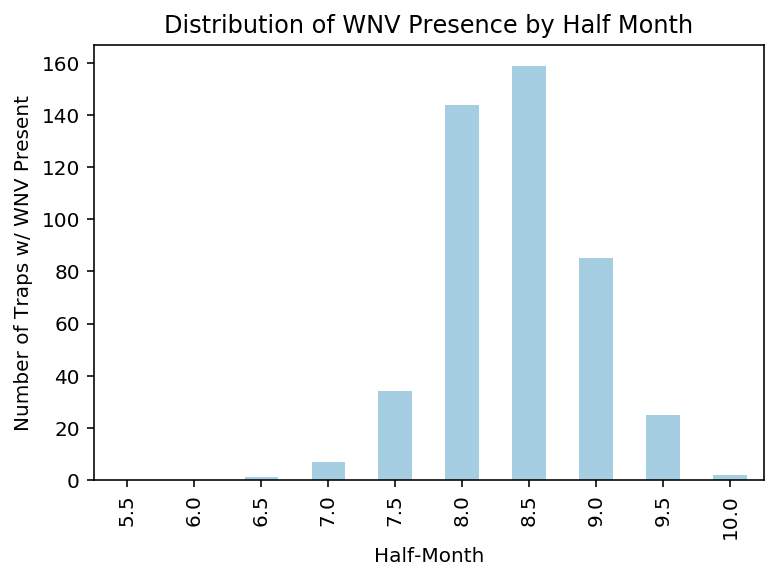

In [25]:
#plot of 
ax = train_data.groupby(by='half_month')['WnvPresent'].sum().plot(kind='bar', 
                                                             colormap='Paired', 
                                                             title='Distribution of WNV Presence by Half Month')
ax.set_xlabel('Half-Month')
ax.set_ylabel('Number of Traps w/ WNV Present');

Distribution of WNV presence by half-months. Skewed right or rather skewed towards the later part of the year. 

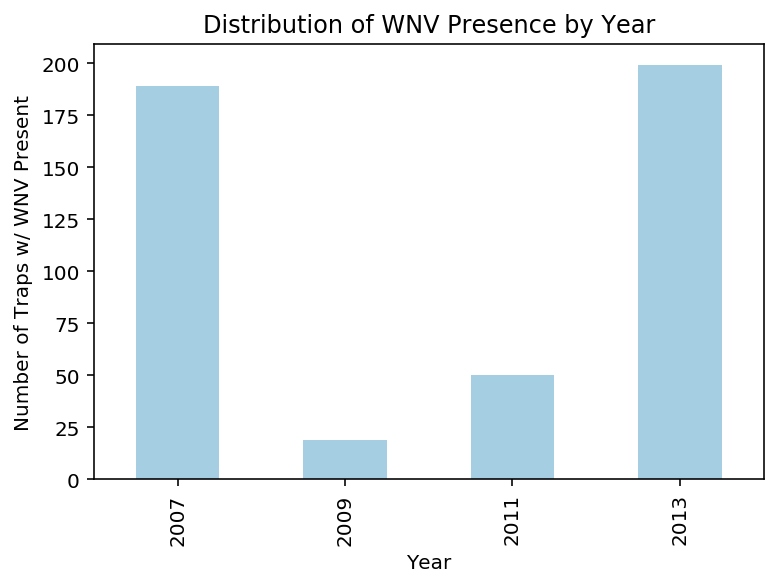

In [26]:
ax = train_data.groupby(by='year')['WnvPresent'].sum().plot(kind='bar', 
                                                       colormap='Paired', 
                                                       title='Distribution of WNV Presence by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Traps w/ WNV Present');

Distribution of WNV presence over the training years. 2007 & 2013 have higher incidences of WNV presence. 

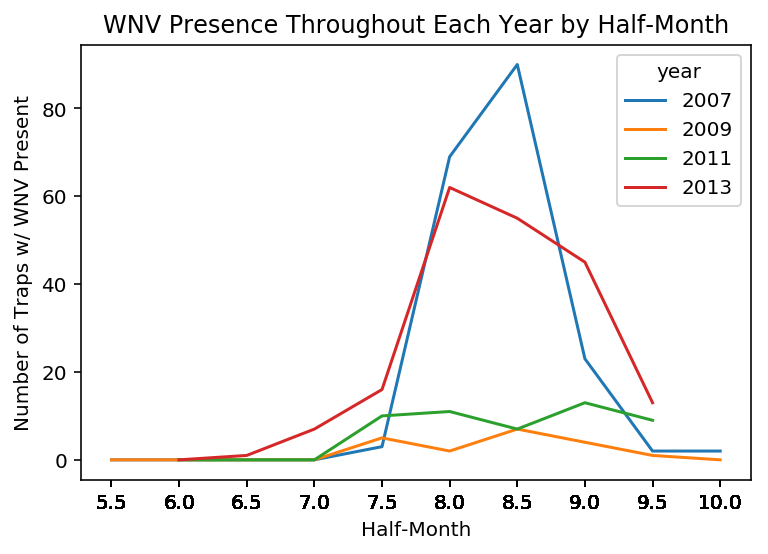

In [27]:
ax = train_data.groupby(by=['year', 'half_month'])['WnvPresent'].sum().unstack(level=0).plot(xticks=train_data['half_month'], 
                                                                                        title='WNV Presence Throughout Each Year by Half-Month')
ax.set_xlabel('Half-Month')
ax.set_ylabel('Number of Traps w/ WNV Present');

Finally, some time series analysis by year for WNV presence throughout each year. The peaking between month's 8 and 9 is clearly seen, but much more prevalent in 2007 & 2013. In this graph, we can see that in 2011, incidences don't trail off as they do in other years. 

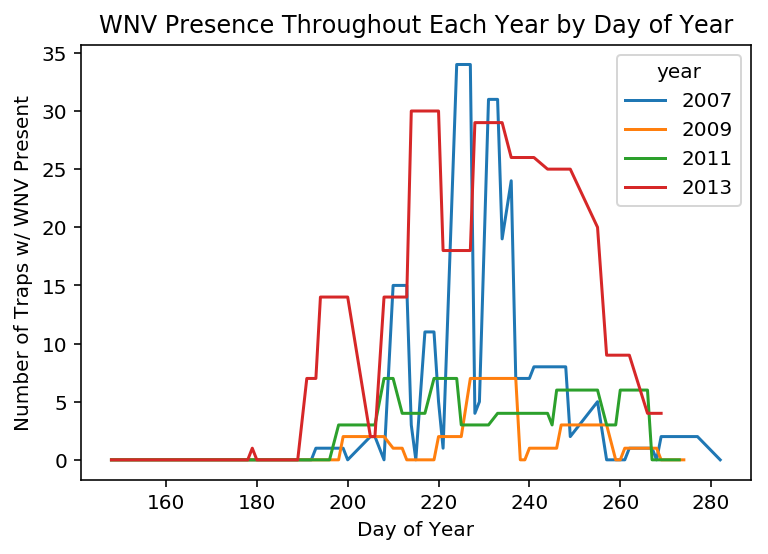

In [28]:
ax = train_data.groupby(by=['year', 'day_of_year'])['WnvPresent'].sum().unstack(level=0).fillna(method='backfill').plot(title='WNV Presence Throughout Each Year by Day of Year')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Number of Traps w/ WNV Present');

Plot of distribution of WNV presence by day of year. Closely mirrors the plot above.

Next I created and visualized clusters where spraying occurred using DBSCAN. Since the spraying occurs in distance based clusters, I felt that DBSCAN was the most appropriate algorithm. DBSCAN uses two parameters, eps (the minimum distance between two points) and minPoints (the minimum number of points to form a dense region), to perform the unsupervised clustering. These parameters were able to be quickly determined based on plotting the resulting spary clusters, as seen below. I also chose not to scale the lat/long coordinates for this clustering exercise as they are the same scale and the resulting clusters are visually inspectable. 

In [29]:
spray_data.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


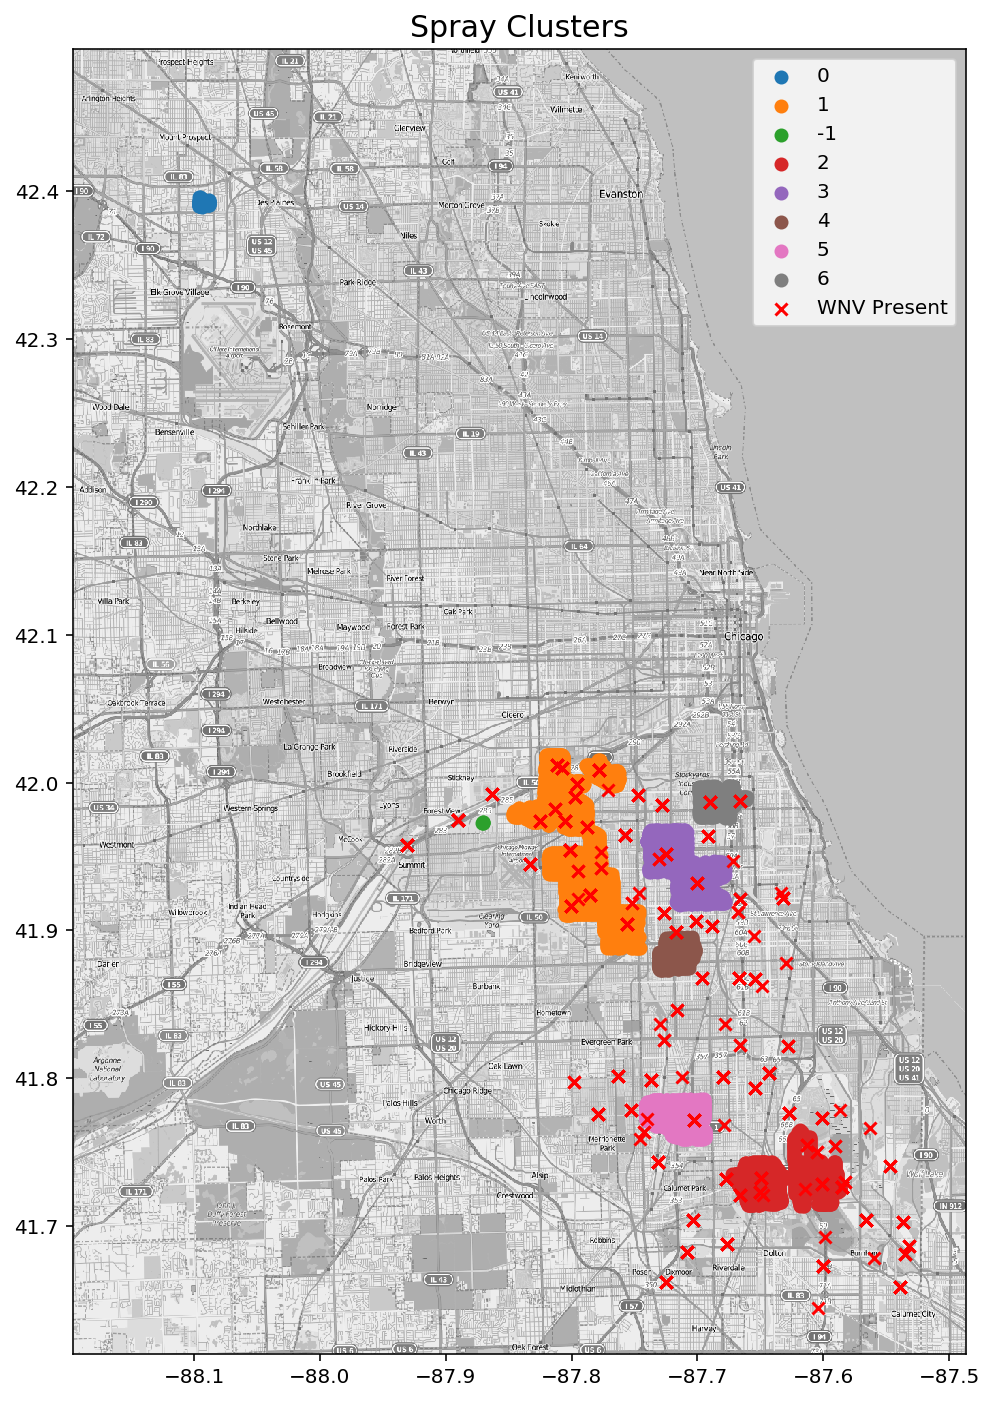

In [30]:
#use BDSCAN to cluster spray data to use to create spray cluster feature
X_spray = spray_data[['Latitude', 'Longitude']] #isolate lat long data
spray_cluster_model = DBSCAN(eps=.01, min_samples=20).fit(X_spray) #run DBSCAN (parameters set after multiple iterations)
X_spray['cluster'] = spray_cluster_model.labels_ #create cluster feature 
#set dimensions of plot
lon_lat_box_spray = (X_spray['Longitude'].min()-.1, X_spray['Longitude'].max()+.1, X_spray['Latitude'].min()-.1,X_spray['Latitude'].max()+.1)

#create plot of spray clusters, for loop allows for legend to represent clusters 
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box_spray) 

#iterate through each cluster value and plot points in the same figure (maintains lables)
for i in X_spray['cluster'].unique():  
    ax.scatter(X_spray[X_spray['cluster'] == i]['Longitude'], 
               X_spray[X_spray['cluster'] == i]['Latitude'], 
               label=i, marker='o')

#overlay WNV presence
plt.scatter(train_data[train_data['WnvPresent'] == 1]['Longitude'], 
            train_data[train_data['WnvPresent'] == 1]['Latitude'], 
            marker='x', label='WNV Present', color='r')
plt.legend()
plt.title('Spray Clusters', size=15);

Spray clusters plotted with WNV presence. Not sure too many insights can be garnered from this plot, but hopefully a feature based on the spray cluster locations will elicit some value. Also not sure where cluster 0 comes from. 

Next, I created some clusters based on location data. Here I used KMeans as that was returning the best grouping of points that I was looking for. I selected 10 clusters based on multiple iterations of visualizing the results. 

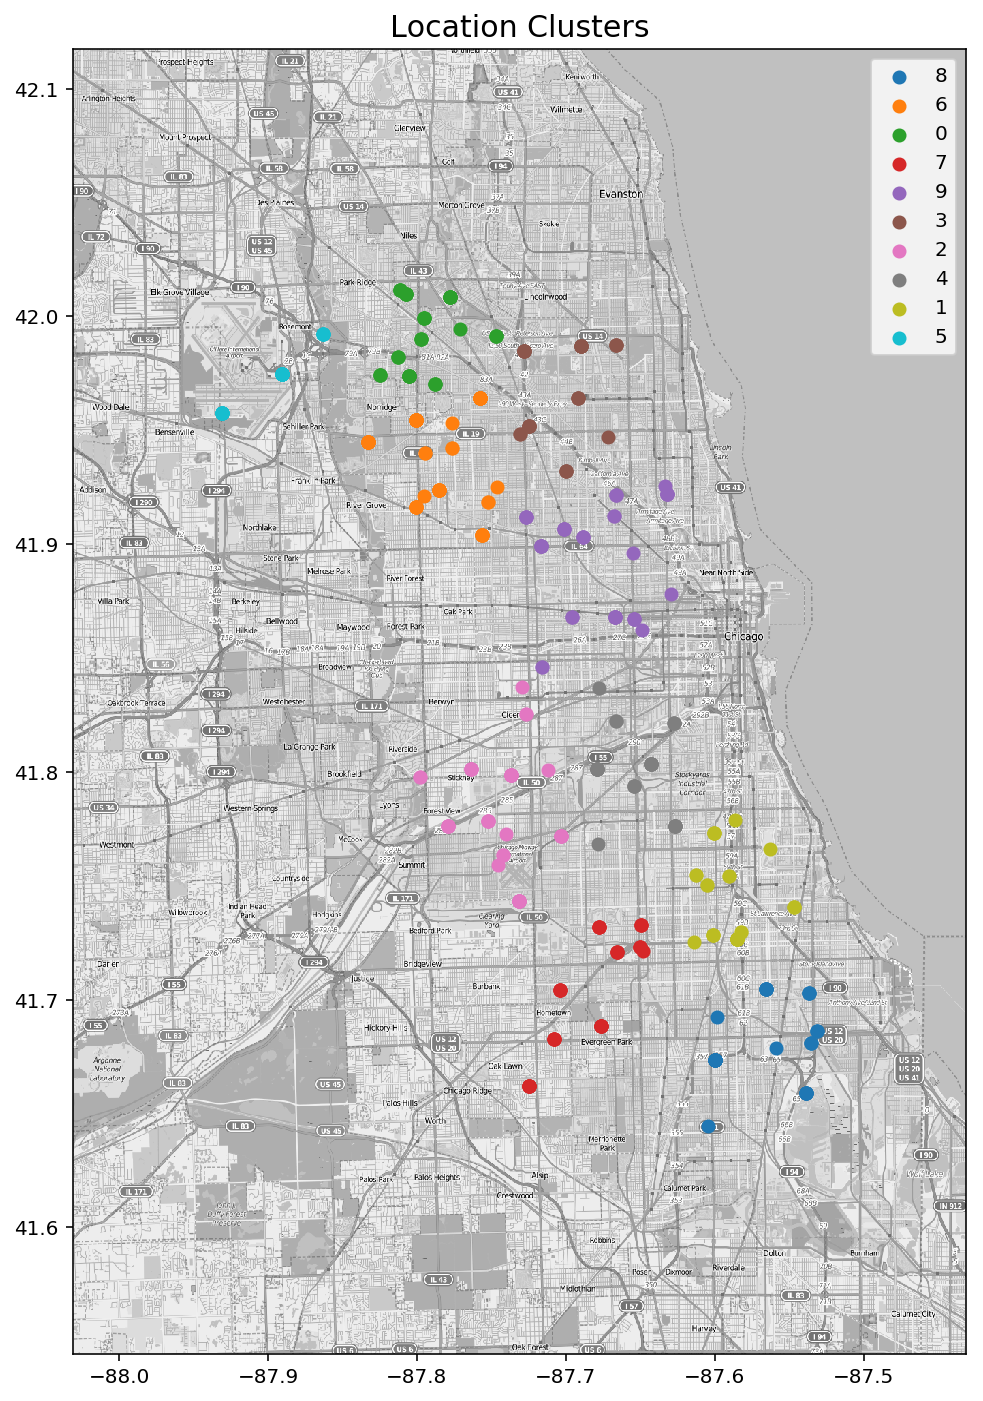

In [31]:
X_clusters = train_data[train_data['WnvPresent'] == 1][['Latitude', 'Longitude']] #isolate positive WNV traps

#create clustering model with KMeans
cluster_model = KMeans(n_clusters=10).fit(X_clusters) #10 clusters selected after a few iterations and reviewing plot below
X_clusters['cluster'] = cluster_model.labels_ #create cluster feature

#plot map
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box) 
#iterate through each cluster value and plot points in the same figure (maintains lables)
for i in X_clusters['cluster'].unique(): 
    ax.scatter(X_clusters[X_clusters['cluster'] == i]['Longitude'], 
               X_clusters[X_clusters['cluster'] == i]['Latitude'], 
               label=i, marker='o')
plt.legend()
plt.title('Location Clusters', size=15);

For my final clustering exercise, I wanted to incorporate an element of time of year for the grouping. This third dimension made it a bit harder to visualize the results and required me to scale the data before performing the unsupervised clustering.

In [32]:
#isolate half_month, lat, long features
X_clusters_month = train_data[train_data['WnvPresent'] == 1][['half_month','Latitude', 'Longitude']]

#scale data
ss = StandardScaler()
X_clusters_month_scaled = ss.fit_transform(X_clusters_month) 

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


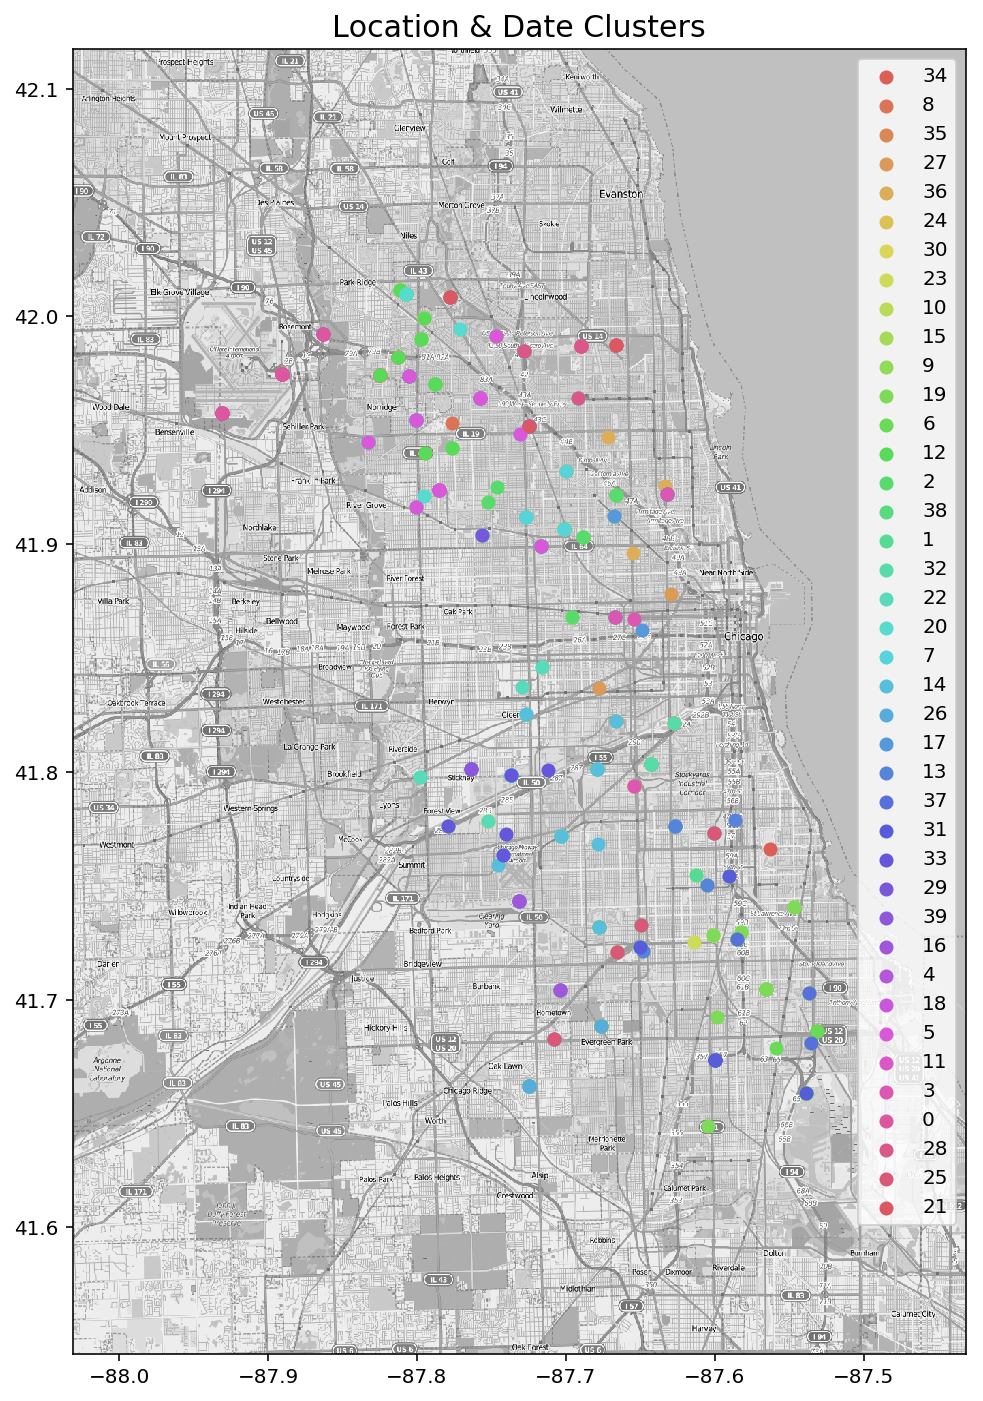

In [33]:
#perform KMeans clustering
clusters = 40 #parameter set from reviewing GIF image below 
cluster_month_model = KMeans(n_clusters=clusters).fit(X_clusters_month_scaled) #fit model on scaled data
X_clusters_month['cluster'] = cluster_month_model.labels_ #create cluster feature


#plot map
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box) 

#iterate through each cluster value and plot points in the same figure (maintains lables)
ax.set_color_cycle(sns.set_palette(sns.color_palette('hls', clusters))) #create color palatte to support number of clusters without repeating colors
for i in X_clusters_month['cluster'].unique(): #iterate through each cluster value and plot points 
    ax.scatter(X_clusters_month[X_clusters_month['cluster'] == i]['Longitude'], 
               X_clusters_month[X_clusters_month['cluster'] == i]['Latitude'], 
               label=i, marker='o')
plt.legend()
plt.title('Location & Date Clusters', size=15);

Plot of location and date clusters. Clustering indiscernable in two dimensional plot. 

In [34]:
#create GIF of time and location 
#iterate through half month and plot points
for i in train_data['half_month'].unique():  
    fig, ax = plt.subplots(figsize=(8,12))
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box) 
    plt.title('Month -' + str(i))
    for j in X_clusters_month['cluster'].unique(): #iterate through each cluster to plot points and maintain labels
        ax.scatter(X_clusters_month[(X_clusters_month['half_month'] == i) & (X_clusters_month['cluster'] == j)]['Longitude'], 
                    X_clusters_month[(X_clusters_month['half_month'] == i) & (X_clusters_month['cluster'] == j)]['Latitude'], 
                    label=j, marker='o')
    plt.legend()
    plt.savefig(f'half_month_{i}.png', bbox_inches='tight') #save plots, 'tight' reduces white space around image
    plt.close(fig); #close each figure instance 

In [35]:
!convert -delay 100 half_month*.png cluster.gif #create GIF from images

![](cluster.gif)

Plot of each time and location cluster. Still a bit harder to see how the clusters carry over half months. However, I think this accomplishes what I intended and will investigate better ways to visualize this overtime. Below, there is code for a 3D plot, but integrating a slider into the plot above may be the best approach.

In [36]:
# #played around with some 3d visulizations of the cluster. feel free to run this cell and play around with the resulting graph
# %matplotlib notebook #command to display 3D plot
# plt.figure(figsize=(7,7)) #set figsize
# ax = plt.subplot(111, projection='3d') #ax parameters for 3 dimensions 
# #plot of the clusters  
# ax.scatter(
#     xs=X_clusters_month['Latitude'], 
#     ys=X_clusters_month['Longitude'],
#     zs=X_clusters_month['half_month'], 
#     c=X_clusters_month['cluster'],
#     cmap='bwr')

I then wrote a function to add the clusters to the train and predict data. This function adds new features based on each of the three clusters. For the spray clusters, since I used DBSCAN to create the clusters and it has no standalone predict method, I needed to use another model to apply those features to the data sets. 

In [37]:
#function to add clusters as features in a dataframe
def add_clusters(df):
    df['cluster'] = cluster_model.predict(df[['Latitude', 'Longitude']]) #since cluster_model is already fitted, just predict on lat, long features of the dataframe
    ss1 = StandardScaler() #new StandardScaler instatiated 
    
    #cluster month model already fitted, so just predict on scaled features
    df['month_cluster'] = cluster_month_model.predict(ss1.fit_transform(df[['month','Latitude','Longitude']])) 
    
    #finally, use random forest classifier to fill in spray clusters
    X = X_spray[['Latitude', 'Longitude']]
    y = X_spray['cluster']
    rf1 = RandomForestClassifier()
    fit1 = rf1.fit(X, y)
    df['spray_cluster'] = fit1.predict(df[['Latitude','Longitude']])

    return df

train_data = add_clusters(train_data)
predict_data = add_clusters(predict_data)

Finally, I added some features that use distance and direction within the clusters. For this, I found the trap with the highest amount of WNV present (sum of positive occurrences) and used the functions from above to calculate the distance and direction for each trap within that cluster. I had to write a slightly altered function for adding these features to the train vs predict data sets, as I needed the information in the train data set when adding to the predict data set. 

In [38]:
#create function to get distance and direction of trap with highest WNV presence within each cluster
def add_features_within_clusters(df):
    #find trap with highest WNV presence within each cluster using groupby and apply functions 
    cluster_group = pd.DataFrame(df.groupby(by=['cluster','Trap'])['WnvPresent'].sum().unstack().T.apply(lambda x: x.idxmax()))
    #iterate through each cluster
    for i in cluster_group.index:
        #add feature for distance and bearing within each cluster
        mask1 = df['cluster'] == i
        df.loc[mask1, 'cluster_distance'] = haversine_array(df.loc[mask1,'Latitude'], df.loc[mask1,'Longitude'], df[df['Trap'] == cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == cluster_group.iloc[i,0]]['Longitude'].iloc[0])
        df.loc[mask1, 'cluster_bearing'] = bearing_array(df.loc[mask1,'Latitude'], df.loc[mask1,'Longitude'], df[df['Trap'] == cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == cluster_group.iloc[i,0]]['Longitude'].iloc[0])
    
    #repeat process below for other clusters
    
    spray_cluster_group = pd.DataFrame(df.groupby(by=['spray_cluster','Trap'])['WnvPresent'].sum().unstack().T.apply(lambda x: x.idxmax()))
    for i in spray_cluster_group.index:
        mask2 = df['spray_cluster'] == i
        df.loc[mask2, 'spray_cluster_distance'] = haversine_array(df.loc[mask2,'Latitude'], df.loc[mask2,'Longitude'], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
        df.loc[mask2, 'spray_cluster_bearing'] = bearing_array(df.loc[mask2,'Latitude'], df.loc[mask2,'Longitude'], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
    
    month_cluster_group = pd.DataFrame(df.groupby(by=['month_cluster','Trap'])['WnvPresent'].sum().unstack().T.apply(lambda x: x.idxmax()))
    for i in month_cluster_group.index:
        mask3 = df['month_cluster'] == i
        df.loc[mask3, 'month_cluster_distance'] = haversine_array(df.loc[mask3,'Latitude'], df.loc[mask3,'Longitude'], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
        df.loc[mask3, 'month_cluster_bearing'] = bearing_array(df.loc[mask3,'Latitude'], df.loc[mask3,'Longitude'], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
    
    return df 

train_data = add_features_within_clusters(train_data)

In [39]:
#need the train data when doing this for predict data set, otherwise function is the same as above
def add_features_within_clusters_predict(df, df_train):
    cluster_group = pd.DataFrame(df_train.groupby(by=['cluster','Trap'])['WnvPresent'].sum().unstack().T.apply(lambda x: x.idxmax()))
    for i in cluster_group.index:
        mask1 = df['cluster'] == i
        df.loc[mask1, 'cluster_distance'] = haversine_array(df.loc[mask1,'Latitude'], df.loc[mask1,'Longitude'], df[df['Trap'] == cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == cluster_group.iloc[i,0]]['Longitude'].iloc[0])
        df.loc[mask1, 'cluster_bearing'] = bearing_array(df.loc[mask1,'Latitude'], df.loc[mask1,'Longitude'], df[df['Trap'] == cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == cluster_group.iloc[i,0]]['Longitude'].iloc[0])
    
    spray_cluster_group = pd.DataFrame(df_train.groupby(by=['spray_cluster','Trap'])['WnvPresent'].sum().unstack().T.apply(lambda x: x.idxmax()))
    for i in spray_cluster_group.index:
        mask2 = df['spray_cluster'] == i
        df.loc[mask2, 'spray_cluster_distance'] = haversine_array(df.loc[mask2,'Latitude'], df.loc[mask2,'Longitude'], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
        df.loc[mask2, 'spray_cluster_bearing'] = bearing_array(df.loc[mask2,'Latitude'], df.loc[mask2,'Longitude'], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == spray_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
    
    month_cluster_group = pd.DataFrame(df_train.groupby(by=['month_cluster','Trap'])['WnvPresent'].sum().unstack().T.apply(lambda x: x.idxmax()))
    for i in month_cluster_group.index:
        mask3 = df['month_cluster'] == i
        df.loc[mask3, 'month_cluster_distance'] = haversine_array(df.loc[mask3,'Latitude'], df.loc[mask3,'Longitude'], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
        df.loc[mask3, 'month_cluster_bearing'] = bearing_array(df.loc[mask3,'Latitude'], df.loc[mask3,'Longitude'], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Latitude'].iloc[0], df[df['Trap'] == month_cluster_group.iloc[i,0]]['Longitude'].iloc[0])
    
    return df 

predict_data = add_features_within_clusters_predict(predict_data, train_data)

The last portion of this section is to make each of the columns that will be dummied recognizable and interpretable when I look at coefficients or feature importances from the models. After that, I just confirm that the train and predict data sets match, except for the two features not present in the predict data. 

In [40]:
#create list of columns that will be dummied
cols_to_dummy = ['Species','Block','Street','Trap','month','half_month','week','cluster','spray_cluster','month_cluster']

def cols_to_dummy_prep(df):
    for i in cols_to_dummy:
        df[i] = df[i].map((lambda x: i + '_' + str(x).replace(' ', '_'))) #add labels to each column for model interpretability
    return df

train_data = cols_to_dummy_prep(train_data)
predict_data = cols_to_dummy_prep(predict_data)

In [41]:
train_data.shape

(8610, 447)

In [42]:
train_data['WnvPresent'].value_counts(normalize=True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

In [43]:
predict_data.set_index('Id',inplace=True)
predict_data.shape

(116293, 445)

In [44]:
assert [cols for cols in train_data.columns if cols not in predict_data.columns] == ['WnvPresent','NumMosquitos_sum']

# Model & Results

For the modeling portion, I used a pipeline based on classes built by my awesome teacher Adam! ModelTransformer allows for multiple scalers to be used in a pipeline. SampleExtractor and DenseTransformer allow CountVectorizer to be used for dummying features without data leakage from train to test or predict datasets. More information can be found on Adam's website: https://blomadam.github.io/.

In addition to the pipepline, I used Train Test Split, StratifiedKFold, and GridSearchCV (Cross Validation) to help determine model parameters. Train test splitting allows for a holdout test set to be created to be scored after the best model parameters are selected through gridsearch with cross validation. StratifiedKFold ensure that the classes are balanced in each CV set, thereby ensuring that the model is trained equally for each class. Cross validation and StratifiedKFold also both ensure that overfitting is reduced. 

By using SMOTE, or Synthetic Minority Over-sampling Technique, I am able to generate new samples of my minority class to use for modeling. This is importance since the positive WNV case is so infrequent. If I did not do this, I could have a model that predicts 100% of traps to be negative for WNV virus the model would be roughly 95% percent accurate. By increasing the number of samples for the minority class using SMOTE, I am able to generate traps with similar conditions to the positive WNV traps to train my model on.

For the models, I choose to use a linear based classification model (SGDClassifier) and a random forest model. The SGDClassifier model is very similar to a logistic regression model, however it utilizes stochastic gradient descent to train the model faster while sacrificing just a bit of accuracy. Ultimately, the xx model performed better on 

The models are evaluated using the metric Area Under the Receiver Operating Characteristic Curve (ROC AUC). The ROC AUC score is based on iterating through different thresholds of probabilites and seeing how the model will predict cases. The metric is based on model predictions evaluated by the true positive and false positive rates at each threshold.

In [45]:
#drop features not used for modeling
train_data.drop(['Date', 'Address','AddressNumberAndStreet', 'NumMosquitos_sum'], axis=1, inplace=True)

In [46]:
#source can be found here: https://blomadam.github.io/.
class ModelTransformer(BaseEstimator,TransformerMixin):

    def __init__(self, model=None):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return self.model.transform(X)
    
class SampleExtractor(BaseEstimator, TransformerMixin):
    """Takes in varaible names as a **list**"""

    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column names to extract

    def transform(self, X, y=None):
        if len(self.vars) > 1:
            return pd.DataFrame(X[self.vars]) # where the actual feature extraction happens
        else:
            return pd.Series(X[self.vars[0]])

    def fit(self, X, y=None):
        return self  # generally does nothing
    
    
class DenseTransformer(BaseEstimator,TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [47]:
#break out each segment of the model so that coefficients/feature importance can be extracted later
species = Pipeline([
              ('text',SampleExtractor(['Species'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
block = Pipeline([
              ('text',SampleExtractor(['Block'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
street = Pipeline([
              ('text',SampleExtractor(['Street'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
trap = Pipeline([
              ('text',SampleExtractor(['Trap'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
month = Pipeline([
              ('text',SampleExtractor(['month'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
half_month = Pipeline([
              ('text',SampleExtractor(['half_month'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
week = Pipeline([
              ('text',SampleExtractor(['week'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
cluster = Pipeline([
              ('text',SampleExtractor(['cluster'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
spray_cluster = Pipeline([
              ('text',SampleExtractor(['spray_cluster'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
month_cluster = Pipeline([
              ('text',SampleExtractor(['month_cluster'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])

In [48]:
#create features and target data from the train data set
X = train_data[[cols for cols in train_data.columns if cols != 'WnvPresent']]
y = train_data['WnvPresent']

X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) #train test split 
strat_kfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=1) #stratified kfolds for cross validation

#create list of features that will not be dummied (i.e. continuous features)
cont_col_list = [cols for cols in X.columns if cols not in cols_to_dummy]

In [49]:
#create pipeline for the SGDClassifier
pipeline_sgd = Pipeline([
    ('features', FeatureUnion([
        ('species', species),
        ('block', block),
        ('street', street),
        ('trap', trap),
        ('month', month),
        ('half_month', half_month),
        ('week', week),
        ('cluster',cluster),
        ('spray_cluster',spray_cluster),
        ('month_cluster',month_cluster),
        ('cont_features', Pipeline([
                      ('continuous', SampleExtractor(cont_col_list)),
                      ])),
        ])),
        ('scale', ModelTransformer()),
        ('sm', SMOTE(ratio='minority', random_state=240)),
        ('sgd', SGDClassifier(loss='log', max_iter=1000, random_state=1)),
])

#create set of parameters to search over for SGDClassifier
params_sgd = {
    'scale__model': [StandardScaler(), MinMaxScaler()],
    'sgd__penalty': ['l1', 'l2', 'elasticnet'],
    'sgd__alpha':[.0001, .001, .01],
    'sgd__l1_ratio':[.01,.05,.15],
}
    
#gridsearch over parameters using StratifiedKFold and 'roc_auc' as scoring metric
gs1 = GridSearchCV(pipeline_sgd,param_grid=params_sgd, cv=strat_kfolds, scoring='roc_auc', verbose=1)
gs1.fit(X_train,y_train) #fit gridsearch to training data
print('best cv score', gs1.best_score_) #print best average CV score
print('best paramas', gs1.best_params_) #print parameters from best CV score
print('test score', gs1.score(X_test, y_test)) #score on test set 

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 144.0min finished


best cv score 0.8297873276325778
best paramas {'scale__model': MinMaxScaler(copy=True, feature_range=(0, 1)), 'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.01, 'sgd__penalty': 'l1'}
test score 0.8798519077489034


In [50]:
# #save best estimator and pickle model to avoid rerunning 
# sgd_model = gs1.best_estimator_

# #pickle/unpickle model below 
# modelfilename= 'sgd_model.sav'
# pickle.dump(sgd_model, open(modelfilename, 'wb'))

# sgd_model = pickle.load(open('sgd_model.sav', 'rb'))

In [59]:
#fit model on all training data and create predictions to submit
sgd_model.fit(X, y) 
test_pred = sgd_model.predict_proba(predict_data)
test_pred = pd.DataFrame(test_pred)
test_pred['Id'] = [i for i in range(1,116294)]
test_pred.rename({1:'WnvPresent'}, axis=1, inplace=True)
test_pred.drop([0],axis=1,inplace=True)
test_pred.to_csv('test_pred_1.csv',index=False)

Kaggle submission score: 0.74527

In [60]:
#extract coefficients for each feature and print out the top 50
feature_names = [] #create empty list
for i in [species, block, street, trap, month, half_month, week, cluster, spray_cluster,month_cluster]: #iterate through each dummied feature
    feature_names.append(i.fit(train_data).steps[1][1].get_feature_names()) #add feature names to list

columns_list = [i for i in X.columns if i not in cols_to_dummy] #create column list of features not dummied

feature_names.append(columns_list) #combine lists of feature names

feature_names = [i for j in feature_names for i in j] #turn list of lists into list of just feature names

#create dataframe of coefficients
coef = pd.DataFrame(feature_names, sgd_model.steps[3][1].coef_.tolist(),columns=['Feature']) 
coef.reset_index(inplace=True)

coef.rename({'level_0':'Coefficient'}, axis=1, inplace=True)

#sort coefficients by magnitude 
coef['abs'] = coef['Coefficient'].abs()
coef50 = coef.sort_values(by='abs',ascending=False)[:50]
coef50

Coefficient                    Feature       abs
436    -4.426957  time_since_max_wnvpresent  4.426957
852    -2.405505     month_cluster_distance  2.405505
664     1.847233           SeaLevel_shift_6  1.847233
359     1.719025                    week_36  1.719025
6      -1.528587    species_culex_territans  1.528587
774     1.510930         ResultDir_shift_12  1.510930
426     1.492089                       year  1.492089
360     1.396742                    week_37  1.396742
341    -1.346012               half_month_6  1.346012
335    -1.346012                    month_6  1.346012
737    -1.188113       ResultSpeed_shift_10  1.188113
700     1.129145           SeaLevel_shift_8  1.129145
2       1.003752      species_culex_pipiens  1.003752
587     0.958672               Cool_shift_2  0.958672
831     0.953022      heavy_rain_8_days_ago  0.953022
433     0.951676             bearing_to_mdw  0.951676
138     0.850352      street__s_kostner_ave  0.850352
254     0.850352                   trap_225  0.850352
190    -0.665871      street__w_montrose_dr  0.665871
238    -0.665871                    trap_17  0.665871
809    -0.652741       ResultSpeed_shift_14  0.652741
461     0.638726             Cool_rolling_3  0.638726
839    -0.579834     heavy_rain_12_days_ago  0.579834
555     0.567457     StnPressure_rolling_30  0.567457
323     0.542355                    trap_90  0.542355
525    -0.542307      day_length_rolling_14  0.542307
719     0.523772        ResultSpeed_shift_9  0.523772
659    -0.514589               Cool_shift_6  0.514589
542     0.499460          RelHum_rolling_21  0.499460
14     -0.490634                   block_18  0.490634
817    -0.488588      heavy_rain_1_days_ago  0.488588
756    -0.481647         ResultDir_shift_11  0.481647
829     0.480361      heavy_rain_7_days_ago  0.480361
833     0.464875      heavy_rain_9_days_ago  0.464875
722     0.461026             RelHum_shift_9  0.461026
507    -0.449931      day_length_rolling_10  0.449931
701     0.445099        ResultSpeed_shift_8  0.445099
212     0.440743                   trap_138  0.440743
419     0.415553            month_cluster_7  0.415553
8       0.403962                   block_11  0.403962
803     0.402612              Cool_shift_14  0.402612
629    -0.402496        ResultSpeed_shift_4  0.402496
755    -0.374309       ResultSpeed_shift_11  0.374309
351    -0.372957                    week_28  0.372957
556     0.359961        SeaLevel_rolling_30  0.359961
366    -0.355506                  cluster_1  0.355506
849     0.347247            cluster_bearing  0.347247
19     -0.334799                   block_25  0.334799
337     0.328591                    month_8  0.328591
343     0.328591               half_month_8  0.328591

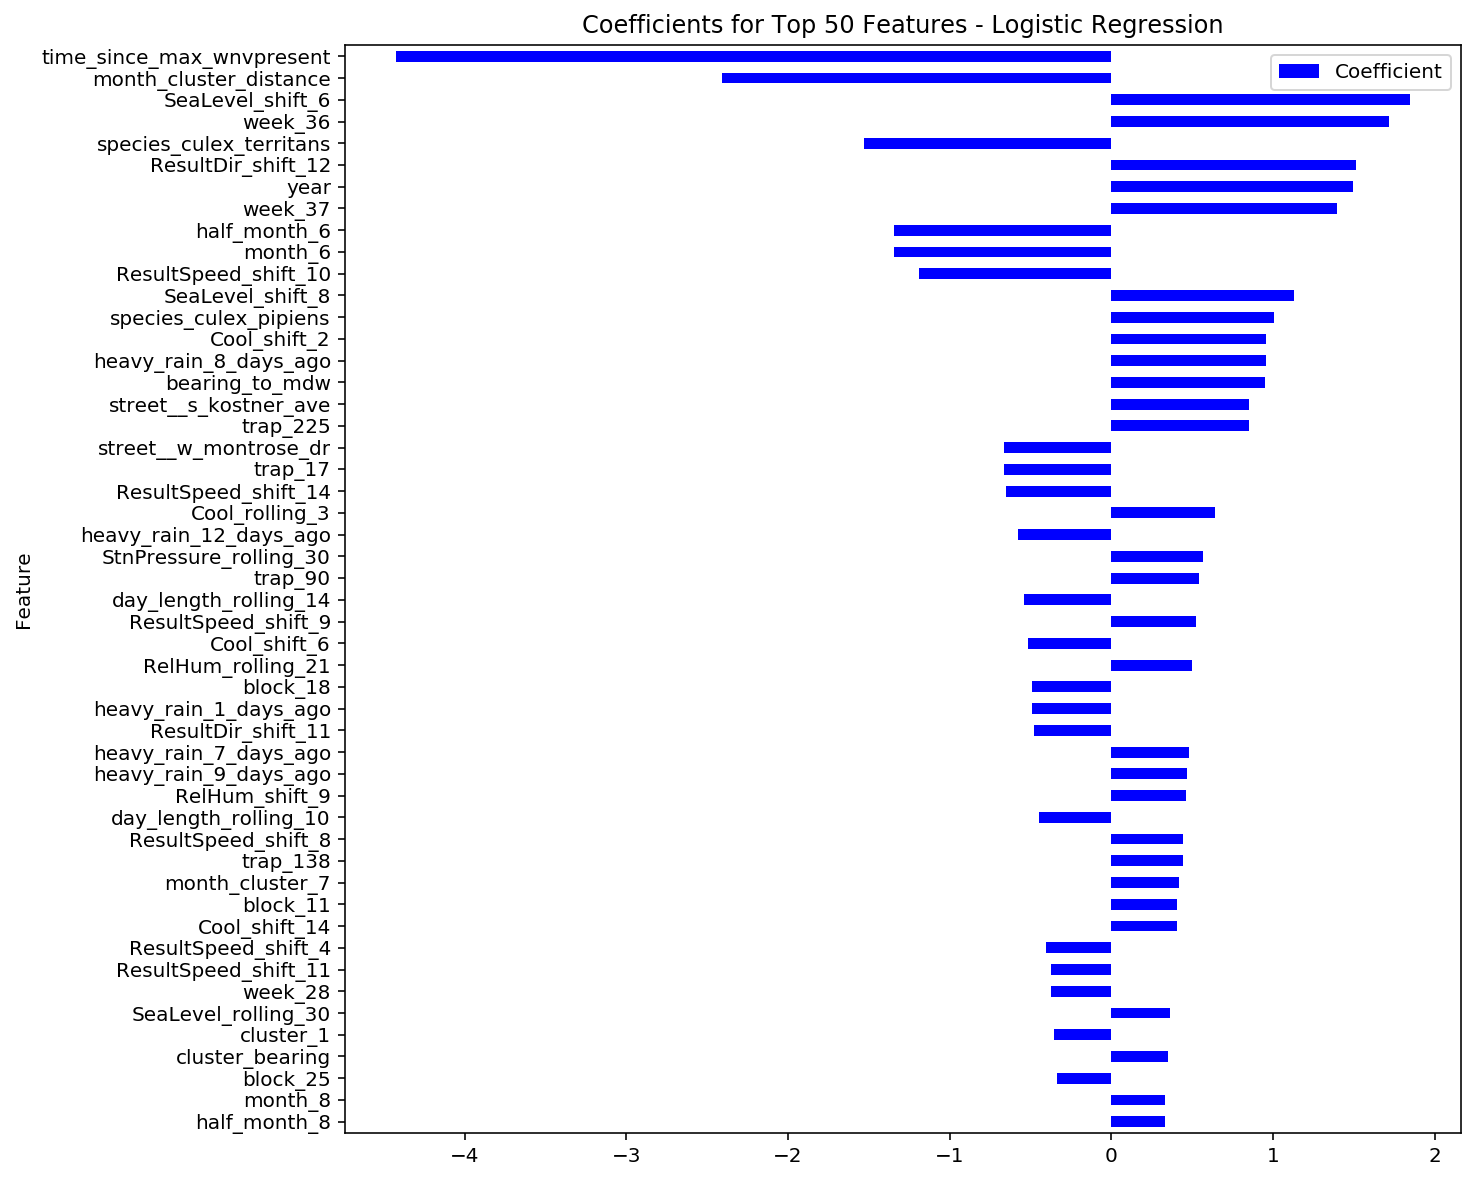

In [61]:
#create plot of coefficients
coef50.sort_values(by='abs').plot(y='Coefficient',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Coefficients for Top 50 Features - Logistic Regression');

Plot of top 50 coefficients for the SGD classification model. Nice blend of time, weather, and location features represented. Also, some of the species data seems to play an important role, which aligns with the fact that only three of the seven species are carriers of WNV, as shown below. 

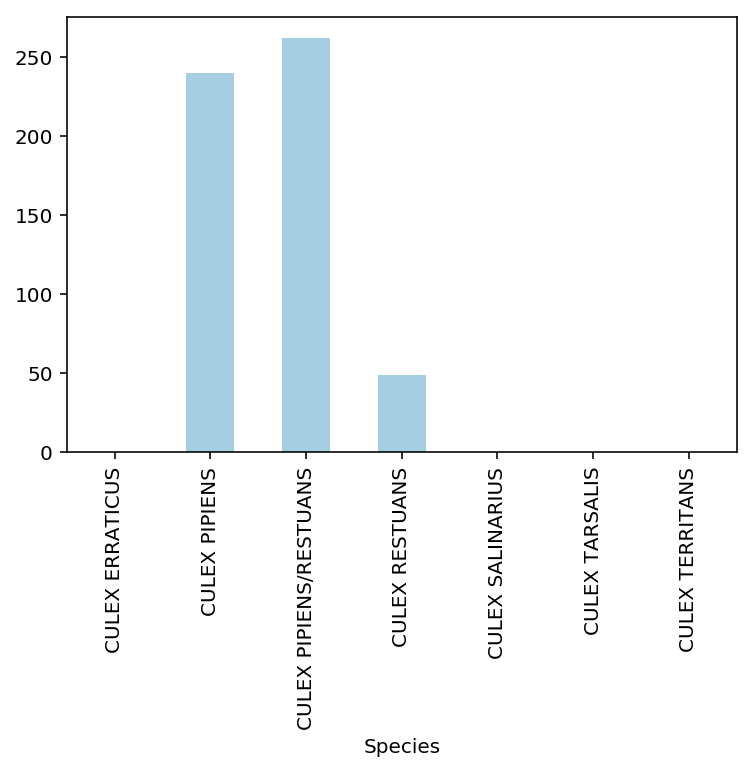

In [30]:
train_data.groupby(by='Species')['WnvPresent'].sum().plot(kind='bar', colormap='Paired');

Distribution of WNV presence by species. Only three out of the seven species are carriers.

In [100]:
#create random forest pipeline and grid search. I did not need to scale the data for the random forest, so that portion is commented away
pipeline_rf = Pipeline([
    ('features', FeatureUnion([
        ('species', species),
        ('block', block),
        ('street', street),
        ('trap', trap),
        ('month', month),
        ('half_month', half_month),
        ('week', week),
        ('cluster',cluster),
        ('spray_cluster',spray_cluster),
        ('month_cluster',month_cluster),
        ('cont_features', Pipeline([
                      ('continuous', SampleExtractor(cont_col_list)),
                      ])),
        ])),
#         ('scale', ModelTransformer()),
        ('sm', SMOTE(ratio='minority',random_state=240)),
        ('rf', RandomForestClassifier(random_state=2)),
])


params_rf = {
#     'scale__model': [StandardScaler(), MinMaxScaler()],
    'rf__n_estimators':[330,340,350],
    'rf__max_features':['auto', 'sqrt'],
    'rf__min_samples_leaf':[10,11,12],
    'rf__max_depth':[6,7,8]
}
    

gs2 = GridSearchCV(pipeline_rf,param_grid=params_rf, cv=strat_kfolds, scoring='roc_auc', verbose=1, n_jobs=-1)
gs2.fit(X_train,y_train)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('test score', gs2.score(X_test, y_test))

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 19.8min finished


best cv score 0.8128132524972225
best paramas {'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 11, 'rf__n_estimators': 340}
test score 0.8622667951300692


In [101]:
# #save best estimator and pickle model to avoid rerunning 
# rf_model = gs2.best_estimator_

# #pickle/unpickle model below 
# modelfilename= 'rf_model.sav'
# pickle.dump(rf_model, open(modelfilename, 'wb'))

# rf_model = pickle.load(open('rf_model.sav', 'rb'))

In [102]:
#fit on all data and make predictions
rf_model.fit(X, y)
test_pred2 = rf_model.predict_proba(predict_data)
test_pred2 = pd.DataFrame(test_pred2)
test_pred2['Id'] = [i for i in range(1,116294)]
test_pred2.rename({1:'WnvPresent'}, axis=1, inplace=True)
test_pred2.drop([0],axis=1,inplace=True)
test_pred2.to_csv('test_pred_2.csv',index=False)

Kaggle score of 0.72105

In [103]:
#extract feature importances and view top 50
feature_importances = pd.DataFrame(feature_names, rf_model.steps[2][1].feature_importances_.tolist(),columns=['Feature'])
feature_importances.reset_index(inplace=True)
feature_importances.rename({'index':'Feature Importance'}, axis=1, inplace=True)

feature_importances.sort_values(by='Feature Importance', ascending=False)[:50]

Feature Importance                    Feature
2              0.028092      species_culex_pipiens
436            0.026683  time_since_max_wnvpresent
425            0.020817                day_of_year
337            0.019463                    month_8
516            0.018874         Sunrise_rolling_14
561            0.015141      day_length_rolling_30
498            0.015032         Sunrise_rolling_10
525            0.013894      day_length_rolling_14
552            0.013770         Sunrise_rolling_30
3              0.012824     species_culex_restuans
343            0.012346               half_month_8
507            0.012168      day_length_rolling_10
549            0.011605         WetBulb_rolling_30
480            0.010601          Sunrise_rolling_5
590            0.010600        PrecipTotal_shift_2
0              0.010137                   restuans
513            0.010136         WetBulb_rolling_14
499            0.010046          Sunset_rolling_10
529            0.009231            Tavg_rolling_21
548            0.008716        DewPoint_rolling_30
512            0.008377        DewPoint_rolling_14
579            0.007889         day_length_shift_1
553            0.007834          Sunset_rolling_30
517            0.007527          Sunset_rolling_14
462            0.007375          Sunrise_rolling_3
759            0.007321        day_length_shift_11
533            0.006973            Cool_rolling_21
534            0.006638         Sunrise_rolling_21
615            0.006523         day_length_shift_3
687            0.006183         day_length_shift_7
571            0.005986             Sunset_shift_1
547            0.005969            Tavg_rolling_30
546            0.005549            Tmin_rolling_30
560            0.005514          RelHum_rolling_30
679            0.005452             Sunset_shift_7
723            0.005195         day_length_shift_9
531            0.005153         WetBulb_rolling_21
527            0.005095            Tmax_rolling_21
550            0.005076            Heat_rolling_30
607            0.005006             Sunset_shift_3
559            0.004956        AvgSpeed_rolling_30
755            0.004827       ResultSpeed_shift_11
530            0.004817        DewPoint_rolling_21
715            0.004564             Sunset_shift_9
751            0.004549            Sunset_shift_11
773            0.004517       ResultSpeed_shift_12
528            0.004412            Tmin_rolling_21
555            0.004405     StnPressure_rolling_30
795            0.004348        day_length_shift_13
426            0.004345                       year

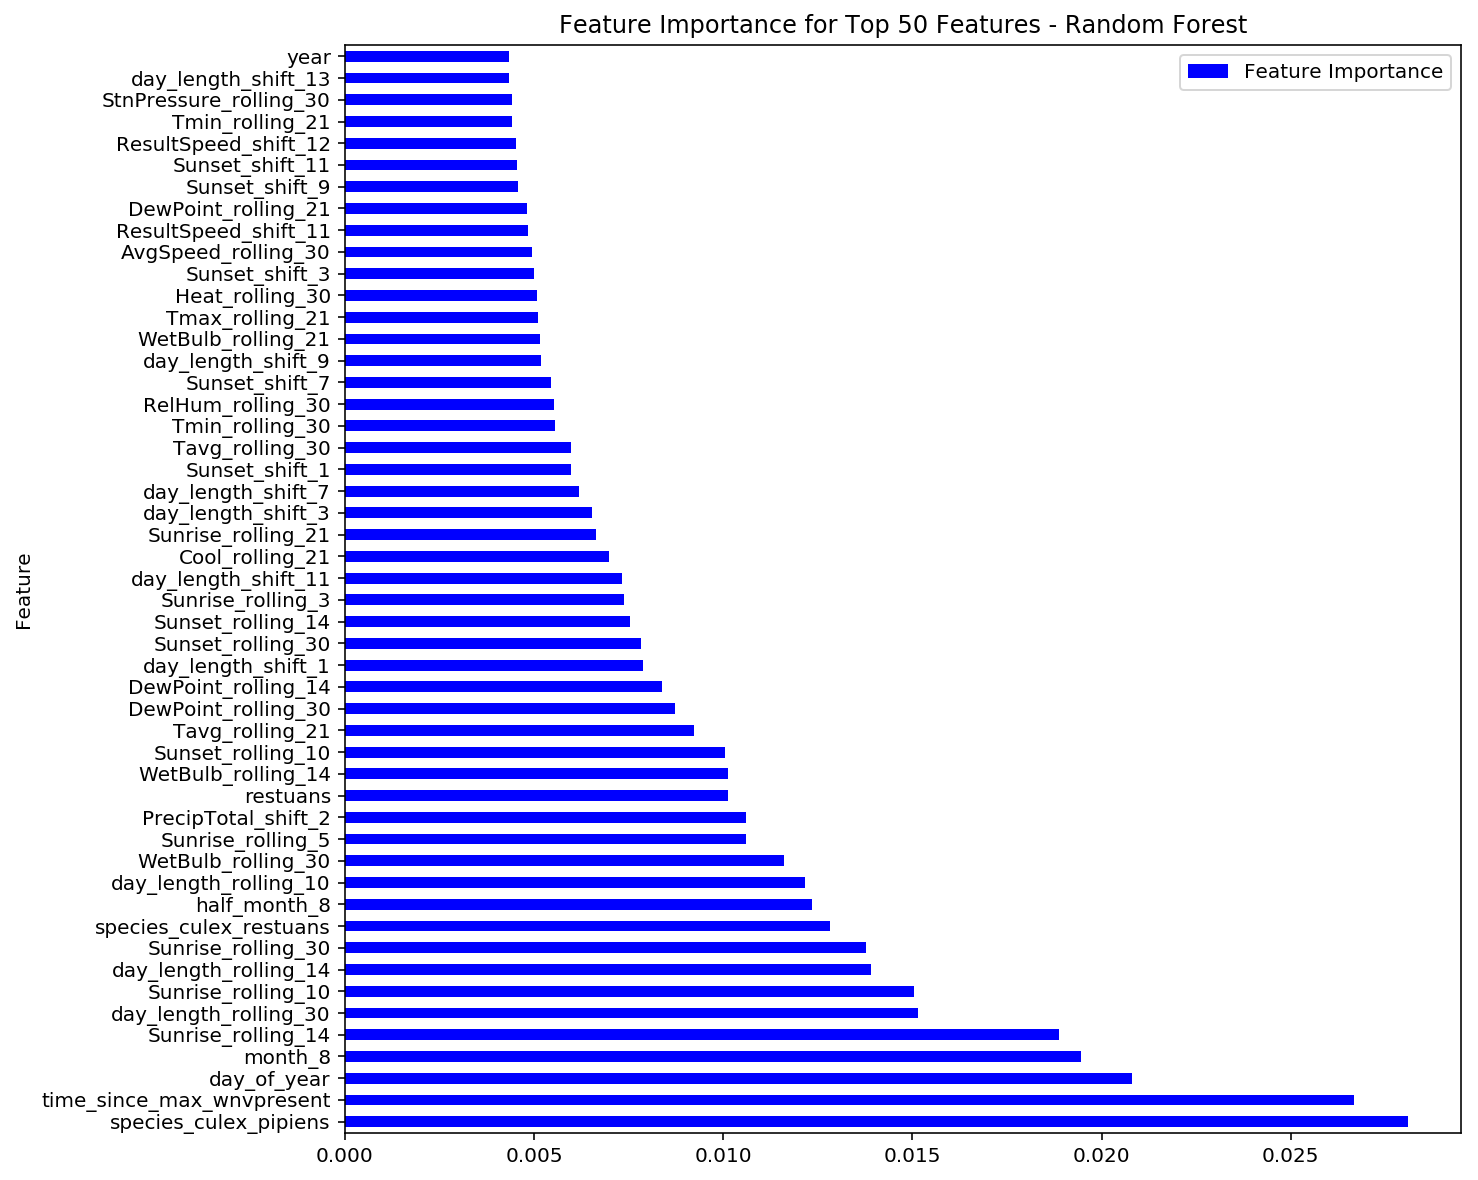

In [104]:
#Plot of top 50 features 
feature_importances.sort_values(by='Feature Importance', ascending=False)[:50].plot(y='Feature Importance',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Feature Importance for Top 50 Features - Random Forest');

Note the differences in the top 50 features for this type of model. For instance, rolling averages appear much more frequently. These top 50 features make sense as they are what results in the lowest Gini impurity when determining splits (i.e. these appear higher in the tree and are therefore weighted more heavily in terms of feature importance).

Finally, I will plot the ROC AUC scores for each model. Helpful code for doing this was found here: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [105]:
#import models that were note fitted on all the train data 
rf_test = pickle.load(open('rf_model.sav', 'rb'))
sgd_test = pickle.load(open('sgd_model.sav', 'rb'))

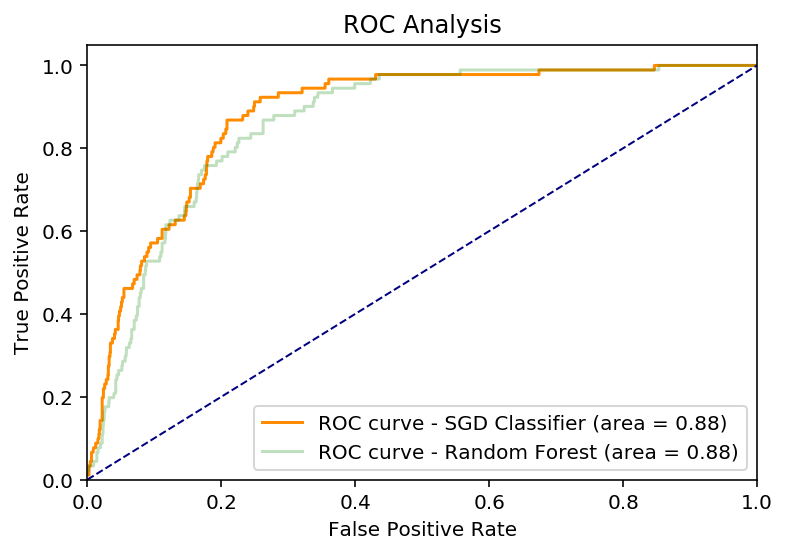

In [113]:
#use roc_curve and auc to calculate the fpr and tpr for all thresholds of the classification for each model
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_test,sgd_test.predict_proba(X_test)[:,1])
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

fpr_rf, tpr_rf, thresholds_sgd = roc_curve(y_test,rf_test.predict_proba(X_test)[:,1])
roc_auc_rf = auc(fpr_sgd, tpr_sgd)

#plot results of each model on the same graph
plt.figure()
plt.plot(fpr_sgd, tpr_sgd, color='darkorange', label='ROC curve - SGD Classifier (area = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_rf, tpr_rf, color='g', alpha=.25, label='ROC curve - Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis')
plt.legend(loc="lower right")
plt.show()

Final results of the two selected models. SGD Classifier slightly better performer based on an ROC AUC score for both the test and prediction set. 

# Wnv Presence Movie Making

WNV presence plot for GIF in the beginning of the doc.

In [33]:
for j in train_data['year'].drop_duplicates().values:
    for i in train_data['month'].drop_duplicates().values:
        z = [0,1]
        label = ['Wnv Present', 'Wnv Not Present']
        colors = ['g','r']
        fig, ax = plt.subplots(figsize=(8,12))
        ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box)
        for k, l, c in zip(z, label, colors):
            plt.title('West Nile Virus (WNV) Presence by Month' + '\n' + 'Month_' + str(i) + ', ' + str(j), size=15) #set a title
            ax.scatter(train_data[(train_data['WnvPresent'] == k) & (train_data['month'] == i) & (train_data['year'] == j)]['Longitude'], 
                        train_data[(train_data['WnvPresent'] == k) & (train_data['month'] == i) & (train_data['year'] == j)]['Latitude'], 
                        marker='o', label=l, color=c)
       
        plt.legend()        
        plt.savefig(f'wnv_{i,j}.png', bbox_inches='tight')
        plt.close(fig);

In [34]:
!convert -delay 75 wnv*.png wnv_presence_month.gif